#### Top

# Chapter 7 Time Series Analysis

* [7.0 Imports and Setup](#7.0-Imports-and-Setup)
* [7.1 Introduction](#7.1-Introduction)
* [7.2 Loading the Dataset](#7.2-Loading-the-Dataset)
* [7.3 Converting to Dates](#7.3-Converting-to-Dates)
* [7.4 Combining Columns to Create Dates](#7.4-Combining-Columns-to-Create-Dates)
* [7.5 Changing Timezones](#7.5-Changing-Timezones)
* [7.6 Time Aggregations](#7.6-Time-Aggregations)
* [7.7 Time Intervals](#7.7-Time-Intervals)
* [7.8 Multiple Groupings with Timeseries](#7.8-Multiple-Groupings-with-Timeseries)
* [7.9 Window Functions in Polars](#7.9-Window-Functions-in-Polars)
* [7.10 Interpolation](#7.10-Interpolation)
* [7.11 Upsampling and Downsampling](#7.11-Upsampling-and-Downsampling)
* [7.12 Joining Time Series Data](#7.12-Joining-Time-Series-Data)
* [7.13 Visualizing the Merged Data](#7.13-Visualizing-the-Merged-Data)
* [7.14 Chapter Methods and Functions](#7.14-Chapter-Methods-and-Functions)


---
# 7.0 Imports and Setup

[back to Top](#Top)

In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import chardet
import pprint as pp
import hvplot.polars
hvplot.extension('matplotlib')

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
pd.options.mode.copy_on_write = True
print(pd.options.mode.copy_on_write)
pl.Config.set_verbose(True)
pl.show_versions()

def HR():
    print("-"*40)

@pl.Config(tbl_cols=-1, ascii_tables=True)
def tight_layout(df: pl.DataFrame, n=5) -> None:
    with pl.Config(tbl_cols=-1, fmt_str_lengths=n):
        print(df)

def detect_encoding(filename: str) -> str:
    """Return the most probable character encoding for a file."""
    with open(filename, "rb") as f:
        raw_data = f.read()
        print(raw_data)
        result = chardet.detect(raw_data)
        return result["encoding"]

True
--------Version info---------
Polars:              1.9.0
Index type:          UInt32
Platform:            macOS-12.7.6-x86_64-i386-64bit
Python:              3.11.5 (main, Jan 16 2024, 17:25:53) [Clang 14.0.0 (clang-1400.0.29.202)]

----Optional dependencies----
adbc_driver_manager  1.1.0
altair               5.4.0
cloudpickle          3.0.0
connectorx           0.3.3
deltalake            0.19.1
fastexcel            0.11.6
fsspec               2023.12.2
gevent               24.2.1
great_tables         0.10.0
matplotlib           3.9.2
nest_asyncio         1.6.0
numpy                2.0.2
openpyxl             3.1.5
pandas               2.2.2
pyarrow              17.0.0
pydantic             2.8.2
pyiceberg            0.6.1
sqlalchemy           2.0.32
torch                <not installed>
xlsx2csv             0.8.3
xlsxwriter           3.2.0


---
# 7.1 Introduction

[back to Top](#Top)

---
# 7.2 Loading the Dataset
[back to Top](#Top)

* Dirty Devil R AB Poison SP Wsh NR Hanksville UT - 09333500
* https://waterdata.usgs.gov/monitoring-location/09333500/#parameterCode=00065&period=P365D&showMedian=false

In [2]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/dirtydevil.txt'
local_filename_raw ='./data/data_river_dirtydevil_raw.txt'
local_filename ='./data/data_river_dirtydevil.txt'

In [3]:
#!wget -nc $url -O $local_filename_raw
#file = open('zzzz.txt', 'w')

In [4]:
import urllib.request
from pathlib import Path

def download_and_modify_url(url, local_filename_raw, local_filename):
    file_path = Path(local_filename_raw)

    # If raw file does not exist, download
    if not Path(local_filename_raw).is_file():
        print(f"Downloading {url}, saving to {local_filename_raw}")
        urllib.request.urlretrieve(url, local_filename_raw)
    else:
        print(f"{local_filename_raw} exists.")

    HR()
    print(f"Reading from {local_filename_raw}")
    with open(local_filename_raw, 'r') as file:
        lines = file.readlines()

    print(f"Cleaning up and saving to {local_filename}")
    with open(local_filename, 'w') as file:
        for i, line in enumerate(lines):
            if i < 34 or i == 35:
                continue
            file.write(line)

download_and_modify_url(url, local_filename_raw, local_filename)

HR()
print(f"Done loading the dataset {local_filename}")

----------------------------------------
Reading from ./data/data_river_dirtydevil_raw.txt
Cleaning up and saving to ./data/data_river_dirtydevil.txt
----------------------------------------
Done loading the dataset ./data/data_river_dirtydevil.txt


In [5]:
!head -n 10 $local_filename_raw

# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database
# may not have received Director's approval. Any such data values are qualified
# as provisional and are subject to revision. Provisional data are released on the
# condition that neither the USGS nor the United States Government may be held liable
# for any damages resulting from its use.
#
# Additional info: https://help.waterdata.usgs.gov/policies/provisional-data-statement
#
# File-format description:  https://help.waterdata.usgs.gov/faq/about-tab-delimited-output


In [6]:
!head -n 10 $local_filename

agency_cd	site_no	datetime	tz_cd	144166_00060	144166_00060_cd	144167_00065	144167_00065_cd
USGS	09333500	2001-05-07 01:00	MDT	71.0	A:[91]		
USGS	09333500	2001-05-07 01:15	MDT	71.0	A:[91]		
USGS	09333500	2001-05-07 01:30	MDT	71.0	A:[91]		
USGS	09333500	2001-05-07 01:45	MDT	70.0	A:[91]		
USGS	09333500	2001-05-07 02:00	MDT	70.0	A:[91]		
USGS	09333500	2001-05-07 02:15	MDT	69.0	A:[91]		
USGS	09333500	2001-05-07 02:30	MDT	70.0	A:[91]		
USGS	09333500	2001-05-07 02:45	MDT	70.0	A:[91]		
USGS	09333500	2001-05-07 03:00	MDT	70.0	A:[91]		


* Load the data and clean it up

In [7]:
# Verify the columns
original_columns=(
    pl.read_csv(local_filename, separator='\t')
    .columns
)
original_columns

avg line length: 49
std. dev. line length: 0
initial row estimate: 531100
no. of chunks: 4 processed by: 4 threads.


['agency_cd',
 'site_no',
 'datetime',
 'tz_cd',
 '144166_00060',
 '144166_00060_cd',
 '144167_00065',
 '144167_00065_cd']

In [8]:
raw = pl.read_csv(local_filename, separator='\t')
raw.head(1)

avg line length: 49
std. dev. line length: 0
initial row estimate: 531100
no. of chunks: 4 processed by: 4 threads.


agency_cd,site_no,datetime,tz_cd,144166_00060,144166_00060_cd,144167_00065,144167_00065_cd
str,i64,str,str,f64,str,str,str
"""USGS""",9333500,"""2001-05-07 01:00""","""MDT""",71.0,"""A:[91]""",null,null


In [9]:
def tweak_river(df_):
    return (
        df_
        .select(
            'agency_cd', 
            'site_no', 
            'tz_cd',
            pl.col('datetime').str.to_datetime(),
            cfs=pl.col('144166_00060'),
            gage_height=pl.col('144167_00065').cast(pl.Float64)
        )
    )

dd = tweak_river(raw)
dd.tail()

agency_cd,site_no,tz_cd,datetime,cfs,gage_height
str,i64,str,datetime[μs],f64,f64
"""USGS""",9333500,"""MDT""",2020-09-28 08:30:00,9.53,6.16
"""USGS""",9333500,"""MDT""",2020-09-28 08:45:00,9.2,6.15
"""USGS""",9333500,"""MDT""",2020-09-28 09:00:00,9.2,6.15
"""USGS""",9333500,"""MDT""",2020-09-28 09:15:00,9.2,6.15
"""USGS""",9333500,"""MDT""",2020-09-28 09:30:00,9.2,6.15


In [10]:
# Check the difference between columns in original and new datasets
set(original_columns) - set(dd.columns)

{'144166_00060', '144166_00060_cd', '144167_00065', '144167_00065_cd'}

---
# 7.3 Converting to Dates

[back to Top](#Top)

We can use these mechanisms to convert strings to dates in Polars

* `try_parse_dates` (in `pl.read_csv)`
* `.str.to_date()`
* `.str.to_datetime()`
* `.str.strptime()`

## 7.3.1 `try_parse_dates=True`

* Try to automatically parse dates. 
* Most ISO8601-like formats can be inferred, as well as a handful of others. 
* If this does not succeed, the column remains of data type pl.String. 
* If use_pyarrow=True, dates will always be parsed.
* https://docs.pola.rs/py-polars/html/reference/api/polars.read_csv.html

In [11]:
(
    pl.read_csv(
        local_filename, 
        separator='\t',
        try_parse_dates=True
    )
).head(5)

avg line length: 49
std. dev. line length: 0
initial row estimate: 531100
no. of chunks: 4 processed by: 4 threads.


agency_cd,site_no,datetime,tz_cd,144166_00060,144166_00060_cd,144167_00065,144167_00065_cd
str,i64,datetime[μs],str,f64,str,str,str
"""USGS""",9333500,2001-05-07 01:00:00,"""MDT""",71.0,"""A:[91]""",null,null
"""USGS""",9333500,2001-05-07 01:15:00,"""MDT""",71.0,"""A:[91]""",null,null
"""USGS""",9333500,2001-05-07 01:30:00,"""MDT""",71.0,"""A:[91]""",null,null
"""USGS""",9333500,2001-05-07 01:45:00,"""MDT""",70.0,"""A:[91]""",null,null
"""USGS""",9333500,2001-05-07 02:00:00,"""MDT""",70.0,"""A:[91]""",null,null


In [12]:
format = '%Y-%m-%d %H:%M'

## 7.3.2 `str.to_datetime`

* Convert a String column into a Datetime column.
* https://docs.pola.rs/py-polars/html/reference/series/api/polars.Series.str.to_datetime.html#polars-series-str-to-datetime

        Series.str.to_datetime(
            format: str | None = None,
            *,
            time_unit: TimeUnit | None = None,
            time_zone: str | None = None,
            strict: bool = True,
            exact: bool = True,
            cache: bool = True,
            utc: bool | None = None,
            use_earliest: bool | None = None,
            ambiguous: Ambiguous | Series = 'raise',
        ) → Series

In [13]:
(
    raw
    .select(
        original=pl.col('datetime'),
        to_datetime=pl.col('datetime').str.to_datetime(format)
    )
).head()

original,to_datetime
str,datetime[μs]
"""2001-05-07 01:00""",2001-05-07 01:00:00
"""2001-05-07 01:15""",2001-05-07 01:15:00
"""2001-05-07 01:30""",2001-05-07 01:30:00
"""2001-05-07 01:45""",2001-05-07 01:45:00
"""2001-05-07 02:00""",2001-05-07 02:00:00


## 7.3.3 `str.to_date`

* Convert a String column into a Date column.
* https://docs.pola.rs/py-polars/html/reference/series/api/polars.Series.str.to_date.html#polars.Series.str.to_date

        Series.str.to_date(
            format: str | None = None,
            *,
            strict: bool = True,
            exact: bool = True,
            cache: bool = True,
        ) → Series

In [14]:
(
    raw
    .select(
        original=pl.col('datetime'),
        to_datetime=pl.col('datetime').str.to_date(format)
    )
).head()

original,to_datetime
str,date
"""2001-05-07 01:00""",2001-05-07
"""2001-05-07 01:15""",2001-05-07
"""2001-05-07 01:30""",2001-05-07
"""2001-05-07 01:45""",2001-05-07
"""2001-05-07 02:00""",2001-05-07


## 7.3.4  `str.strptime`

* Convert a String column into a Date/Datetime/Time column.
* https://docs.pola.rs/py-polars/html/reference/series/api/polars.Series.str.strptime.html#polars.Series.str.strptime

        Series.str.strptime(
            dtype: PolarsTemporalType,
            format: str | None = None,
            *,
            strict: bool = True,
            exact: bool = True,
            cache: bool = True,
            use_earliest: bool | None = None,
            ambiguous: Ambiguous | Series = 'raise',
        ) → Series



In [15]:
(
    raw
    .select(
        original=pl.col('datetime'),
        # `dtype` must be of type {Date, Datetime, Time}
        to_datetime=pl.col('datetime').str.strptime(pl.Datetime, format)
    )
).head()

original,to_datetime
str,datetime[μs]
"""2001-05-07 01:00""",2001-05-07 01:00:00
"""2001-05-07 01:15""",2001-05-07 01:15:00
"""2001-05-07 01:30""",2001-05-07 01:30:00
"""2001-05-07 01:45""",2001-05-07 01:45:00
"""2001-05-07 02:00""",2001-05-07 02:00:00


## 7.3.5 Casting to pl.Datetime

* Casting the string to a `pl.Datetime` object using `.cast` will fail.

In [16]:
try:
    print(
        raw
        .select(original=pl.col('datetime'),
        cast=pl.col('datetime').cast(pl.Datetime)
        )
    )
except Exception as e:
    print(e)

conversion from `str` to `datetime[μs]` failed in column 'datetime' for 134277 out of 134277 values: ["2001-05-07 01:00", "2001-05-07 01:15", … "2008-09-25 21:45"]

You might want to try:
- setting `strict=False` to set values that cannot be converted to `null`
- using `str.strptime`, `str.to_date`, or `str.to_datetime` and providing a format string


---
# 7.4 Combining Columns to Create Dates

[back to Top](#Top)

* We want to create a date from two string columns, *month* and *year*.
* Assuming we don't have a time component in this example, create a day for the first of each month.

## 7.4.1 chrono formats
* Formats in chrono strftime. Example: "%y-%m-%d".
* https://docs.rs/chrono/latest/chrono/format/strftime/index.html

| Spec. | Example  | Description                                                                |
|-------|----------|----------------------------------------------------------------------------|
|       |          | **DATE SPECIFIERS:**                                                       |
| `%Y`  | `2001`   | The full proleptic Gregorian year, zero-padded to 4 digits. chrono supports years from -262144 to 262143. Note: years before 1 BCE or after 9999 CE, require an initial sign (+/-).|
| `%C`  | `20`     | The proleptic Gregorian year divided by 100, zero-padded to 2 digits. [^1] |
| `%y`  | `01`     | The proleptic Gregorian year modulo 100, zero-padded to 2 digits. [^1]     |
|       |          |                                                                            |
| `%m`  | `07`     | Month number (01--12), zero-padded to 2 digits.                            |
| `%b`  | `Jul`    | Abbreviated month name. Always 3 letters.                                  |
| `%B`  | `July`   | Full month name. Also accepts corresponding abbreviation in parsing.       |
| `%h`  | `Jul`    | Same as `%b`.                                                              |
|       |          |                                                                            |
| `%d`  | `08`     | Day number (01--31), zero-padded to 2 digits.                              |
| `%e`  | ` 8`     | Same as `%d` but space-padded. Same as `%_d`.                              |
|       |          |                                                                            |
| `%a`  | `Sun`    | Abbreviated weekday name. Always 3 letters.                                |
| `%A`  | `Sunday` | Full weekday name. Also accepts corresponding abbreviation in parsing.     |
| `%w`  | `0`      | Sunday = 0, Monday = 1, ..., Saturday = 6.                                 |
| `%u`  | `7`      | Monday = 1, Tuesday = 2, ..., Sunday = 7. (ISO 8601)                       |
|       |          |                                                                            |
| `%U`  | `28`     | Week number starting with Sunday (00--53), zero-padded to 2 digits. [^2]   |
| `%W`  | `27`     | Same as `%U`, but week 1 starts with the first Monday in that year instead.|
|       |          |                                                                            |
| `%G`  | `2001`   | Same as `%Y` but uses the year number in ISO 8601 week date. [^3]          |
| `%g`  | `01`     | Same as `%y` but uses the year number in ISO 8601 week date. [^3]          |
| `%V`  | `27`     | Same as `%U` but uses the week number in ISO 8601 week date (01--53). [^3] |
|       |          |                                                                            |
| `%j`  | `189`    | Day of the year (001--366), zero-padded to 3 digits.                       |
|       |          |                                                                            |
| `%D`  | `07/08/01`    | Month-day-year format. Same as `%m/%d/%y`.                            |
| `%x`  | `07/08/01`    | Locale's date representation (e.g., 12/31/99).                        |
| `%F`  | `2001-07-08`  | Year-month-day format (ISO 8601). Same as `%Y-%m-%d`.                 |
| `%v`  | ` 8-Jul-2001` | Day-month-year format. Same as `%e-%b-%Y`.                            |
|       |          |                                                                            |
|       |          | **TIME SPECIFIERS:**                                                       |
| `%H`  | `00`     | Hour number (00--23), zero-padded to 2 digits.                             |
| `%k`  | ` 0`     | Same as `%H` but space-padded. Same as `%_H`.                              |
| `%I`  | `12`     | Hour number in 12-hour clocks (01--12), zero-padded to 2 digits.           |
| `%l`  | `12`     | Same as `%I` but space-padded. Same as `%_I`.                              |
|       |          |                                                                            |
| `%P`  | `am`     | `am` or `pm` in 12-hour clocks.                                            |
| `%p`  | `AM`     | `AM` or `PM` in 12-hour clocks.                                            |
|       |          |                                                                            |
| `%M`  | `34`     | Minute number (00--59), zero-padded to 2 digits.                           |
| `%S`  | `60`     | Second number (00--60), zero-padded to 2 digits. [^4]                      |
| `%f`  | `26490000`    | Number of nanoseconds since last whole second. [^7]                   |
| `%.f` | `.026490`| Decimal fraction of a second. Consumes the leading dot. [^7]               |
| `%.3f`| `.026`        | Decimal fraction of a second with a fixed length of 3.                |
| `%.6f`| `.026490`     | Decimal fraction of a second with a fixed length of 6.                |
| `%.9f`| `.026490000`  | Decimal fraction of a second with a fixed length of 9.                |
| `%3f` | `026`         | Decimal fraction of a second like `%.3f` but without the leading dot. |
| `%6f` | `026490`      | Decimal fraction of a second like `%.6f` but without the leading dot. |
| `%9f` | `026490000`   | Decimal fraction of a second like `%.9f` but without the leading dot. |
|       |               |                                                                       |
| `%R`  | `00:34`       | Hour-minute format. Same as `%H:%M`.                                  |
| `%T`  | `00:34:60`    | Hour-minute-second format. Same as `%H:%M:%S`.                        |
| `%X`  | `00:34:60`    | Locale's time representation (e.g., 23:13:48).                        |
| `%r`  | `12:34:60 AM` | Locale's 12 hour clock time. (e.g., 11:11:04 PM). Falls back to `%X` if the locale does not have a 12 hour clock format. |
|       |          |                                                                            |
|       |          | **TIME ZONE SPECIFIERS:**                                                  |
| `%Z`  | `ACST`   | Local time zone name. Skips all non-whitespace characters during parsing. Identical to `%:z` when formatting. [^8] |
| `%z`  | `+0930`  | Offset from the local time to UTC (with UTC being `+0000`).                |
| `%:z` | `+09:30` | Same as `%z` but with a colon.                                             |
|`%::z`|`+09:30:00`| Offset from the local time to UTC with seconds.                            |
|`%:::z`| `+09`    | Offset from the local time to UTC without minutes.                         |
| `%#z` | `+09`    | *Parsing only:* Same as `%z` but allows minutes to be missing or present.  |
|       |          |                                                                            |
|       |          | **DATE & TIME SPECIFIERS:**                                                |
|`%c`|`Sun Jul  8 00:34:60 2001`|Locale's date and time (e.g., Thu Mar  3 23:05:25 2005).       |
| `%+`  | `2001-07-08T00:34:60.026490+09:30` | ISO 8601 / RFC 3339 date & time format. [^5]     |
|       |               |                                                                       |
| `%s`  | `994518299`   | UNIX timestamp, the number of seconds since 1970-01-01 00:00 UTC. [^6]|
|       |          |                                                                            |
|       |          | **SPECIAL SPECIFIERS:**                                                    |
| `%t`  |          | Literal tab (`\t`).                                                        |
| `%n`  |          | Literal newline (`\n`).                                                    |
| `%%`  |          | Literal percent sign.                                                      |

In [17]:
(
    raw
    .select(
        to_datetime=pl.col('datetime').str.to_datetime(format),
    )
    # This needs be executed sequentially, so needs a `.with_columns` context
    .with_columns(
        month=pl.col('to_datetime').dt.strftime('%m'),
        month_name=pl.col('to_datetime').dt.strftime('%B'),
        year=pl.col('to_datetime').dt.strftime('%Y')
    )
)

to_datetime,month,month_name,year
datetime[μs],str,str,str
2001-05-07 01:00:00,"""05""","""May""","""2001"""
2001-05-07 01:15:00,"""05""","""May""","""2001"""
2001-05-07 01:30:00,"""05""","""May""","""2001"""
2001-05-07 01:45:00,"""05""","""May""","""2001"""
2001-05-07 02:00:00,"""05""","""May""","""2001"""
…,…,…,…
2020-09-28 08:30:00,"""09""","""September""","""2020"""
2020-09-28 08:45:00,"""09""","""September""","""2020"""
2020-09-28 09:00:00,"""09""","""September""","""2020"""


## 7.4.2 `polars.date`

* Create a Polars literal expression of type Date.
* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.date.html

```
polars.date(
    year: Expr | str | int,
    month: Expr | str | int,
    day: Expr | str | int) → Expr[source]
```

---
Here, we will use `pl.date()` to combine the existing values into a date.

In [18]:
raw

agency_cd,site_no,datetime,tz_cd,144166_00060,144166_00060_cd,144167_00065,144167_00065_cd
str,i64,str,str,f64,str,str,str
"""USGS""",9333500,"""2001-05-07 01:00""","""MDT""",71.0,"""A:[91]""",null,null
"""USGS""",9333500,"""2001-05-07 01:15""","""MDT""",71.0,"""A:[91]""",null,null
"""USGS""",9333500,"""2001-05-07 01:30""","""MDT""",71.0,"""A:[91]""",null,null
"""USGS""",9333500,"""2001-05-07 01:45""","""MDT""",70.0,"""A:[91]""",null,null
"""USGS""",9333500,"""2001-05-07 02:00""","""MDT""",70.0,"""A:[91]""",null,null
…,…,…,…,…,…,…,…
"""USGS""",9333500,"""2020-09-28 08:30""","""MDT""",9.53,"""P""","""6.16""","""P"""
"""USGS""",9333500,"""2020-09-28 08:45""","""MDT""",9.2,"""P""","""6.15""","""P"""
"""USGS""",9333500,"""2020-09-28 09:00""","""MDT""",9.2,"""P""","""6.15""","""P"""


In [19]:
# return single column
(
    raw
    .select(to_datetime=pl.col('datetime').str.to_datetime(format))
    .with_columns(
        month=pl.col('to_datetime').dt.strftime('%m'),
        year=pl.col('to_datetime').dt.strftime('%Y')
    )
    .select(pl.date(
        pl.col('year'), pl.col('month'), 1
    ))
)

date
date
2001-05-01
2001-05-01
2001-05-01
2001-05-01
2001-05-01
…
2020-09-01
2020-09-01
2020-09-01


In [20]:
# return dataframe with intermediate values for checking
(
    raw
    .select(to_datetime=pl.col('datetime').str.to_datetime(format))
    .with_columns(
        year=pl.col('to_datetime').dt.strftime('%Y'), 
        month=pl.col('to_datetime').dt.strftime('%m'),
    )
    .with_columns(
        ISO_8601_date=pl.date(
            pl.col('year'), 
            pl.col('month'),
            1
        ),
        ISO_8601_date_time=pl.datetime(
            pl.col('year'), 
            pl.col('month'),
            1
        )
    )
)

to_datetime,year,month,ISO_8601_date,ISO_8601_date_time
datetime[μs],str,str,date,datetime[μs]
2001-05-07 01:00:00,"""2001""","""05""",2001-05-01,2001-05-01 00:00:00
2001-05-07 01:15:00,"""2001""","""05""",2001-05-01,2001-05-01 00:00:00
2001-05-07 01:30:00,"""2001""","""05""",2001-05-01,2001-05-01 00:00:00
2001-05-07 01:45:00,"""2001""","""05""",2001-05-01,2001-05-01 00:00:00
2001-05-07 02:00:00,"""2001""","""05""",2001-05-01,2001-05-01 00:00:00
…,…,…,…,…
2020-09-28 08:30:00,"""2020""","""09""",2020-09-01,2020-09-01 00:00:00
2020-09-28 08:45:00,"""2020""","""09""",2020-09-01,2020-09-01 00:00:00
2020-09-28 09:00:00,"""2020""","""09""",2020-09-01,2020-09-01 00:00:00


---
# 7.5 Changing Timezones
[back to Top](#Top)

* If the column is a date type, you can inspect the current time zone by pulling off the `.time_zone` attribute of the `.dtype` property.

In [21]:
# shortcut to create a series
type(dd['datetime'])

polars.series.series.Series

In [22]:
print(
    tweak_river(raw)
    ['datetime']
    .dtype.time_zone
)

None


In [23]:
print(
    dd
    .select(pl.col('datetime'))
    .to_series()
    .dtype.time_zone
)

None


* This *datetime* column currently has no timezone information.
* We can add a time zone to naive date using `.dt.replace_time_zone()`.
* Convert the times to UTC time-standard.
* Then convert to a different time zone with `.dt.convert_time_zone()`.

In [24]:
# Check valid time zones from the pytz library
import pytz

pytz.all_timezones[:5]

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara']

**IMPROPER TIMEZONE CALCULATION**

* All of the below result in improper timezone calculations.

In [25]:
format = '%Y-%m-%d %H:%M'

raw_timezone_invalid=(
    raw
    .select(
        original=pl.col('datetime'),
        naive=pl.col('datetime').str.to_datetime(format),
        utc=pl.col('datetime').str.to_datetime(format).dt.replace_time_zone('UTC'),
        Denver=pl.col('datetime').str.to_datetime(format)
            .dt.replace_time_zone('UTC')
            .dt.convert_time_zone('America/Denver'),        
        Denver3=(
            pl.col('datetime').str.to_datetime(
                format, time_zone='America/Denver', ambiguous='earliest'
            )
        ) 
    )
)
raw_timezone_invalid

original,naive,utc,Denver,Denver3
str,datetime[μs],"datetime[μs, UTC]","datetime[μs, America/Denver]","datetime[μs, America/Denver]"
"""2001-05-07 01:00""",2001-05-07 01:00:00,2001-05-07 01:00:00 UTC,2001-05-06 19:00:00 MDT,2001-05-07 01:00:00 MDT
"""2001-05-07 01:15""",2001-05-07 01:15:00,2001-05-07 01:15:00 UTC,2001-05-06 19:15:00 MDT,2001-05-07 01:15:00 MDT
"""2001-05-07 01:30""",2001-05-07 01:30:00,2001-05-07 01:30:00 UTC,2001-05-06 19:30:00 MDT,2001-05-07 01:30:00 MDT
"""2001-05-07 01:45""",2001-05-07 01:45:00,2001-05-07 01:45:00 UTC,2001-05-06 19:45:00 MDT,2001-05-07 01:45:00 MDT
"""2001-05-07 02:00""",2001-05-07 02:00:00,2001-05-07 02:00:00 UTC,2001-05-06 20:00:00 MDT,2001-05-07 02:00:00 MDT
…,…,…,…,…
"""2020-09-28 08:30""",2020-09-28 08:30:00,2020-09-28 08:30:00 UTC,2020-09-28 02:30:00 MDT,2020-09-28 08:30:00 MDT
"""2020-09-28 08:45""",2020-09-28 08:45:00,2020-09-28 08:45:00 UTC,2020-09-28 02:45:00 MDT,2020-09-28 08:45:00 MDT
"""2020-09-28 09:00""",2020-09-28 09:00:00,2020-09-28 09:00:00 UTC,2020-09-28 03:00:00 MDT,2020-09-28 09:00:00 MDT


**VALID TIMEZONE CALCULATION**

* The data is from the *America/Denver* time zones, so we try to get it in that format.
* We need information from the *tz_cd* column to get the correct time zone.
* Polars has issues parsing the *tz_cd* column, so we need string manipulation to convert the names to offsets.
* Convert the *tz_cd* column to an offset and tack that onto the end of the `datetime` column.
* Then convert that to a date time that includes offset information.
* Convert that to the *American/Denver* time zones. 

In [26]:
raw.select(pl.col('tz_cd')).unique()

tz_cd
str
"""MDT"""
"""MST"""


In [27]:
format = '%Y-%m-%d %H:%M'

raw_timezone_valid=(
    raw
    .select(
        Denver2=( # Denver2 is the correct time
            # pl.col('datetime') # "2001-05-07 01:00"
            
            pl.col('datetime') + ' ' + 
                (pl.col('tz_cd').str.replace('MST', '-0700').str.replace('MDT', '-0600')
            )
        ) # "2001-05-07 01:00 -0600"
        #.str.to_datetime('%Y-%m-%d %H:%M %z') # 2001-05-07 07:00:00 UTC
        #.dt.convert_time_zone('America/Denver'), # 2001-05-07 01:00:00 MDT
        
    )
)

raw_timezone_valid

Denver2
str
"""2001-05-07 01:00 -0600"""
"""2001-05-07 01:15 -0600"""
"""2001-05-07 01:30 -0600"""
"""2001-05-07 01:45 -0600"""
"""2001-05-07 02:00 -0600"""
…
"""2020-09-28 08:30 -0600"""
"""2020-09-28 08:45 -0600"""
"""2020-09-28 09:00 -0600"""


* Using the *ambiguous* argument on `.str.to_datetime()` can result in inaccurate results.

        Determine how to deal with ambiguous datetimes:
            'raise' (default): raise
            'earliest': use the earliest datetime
            'latest': use the latest datetime
            'null': set to null

In [28]:
# Check where Denver3 is invalid
format = '%Y-%m-%d %H:%M'

try: (
        raw
        .select(
    
            # Invalid
            Denver3=(
                pl.col('datetime')
                .str.to_datetime(format, time_zone='America/Denver', ambiguous='null')
            )
        )
    )
except Exception as e:
    print(e)

conversion from `str` to `datetime[μs, America/Denver]` failed in column 'datetime' for 32 out of 136019 values: ["2008-11-02 01:00", "2008-11-02 01:00", … "2011-11-06 01:45"]

You might want to try:
- setting `strict=False` to set values that cannot be converted to `null`
- using `str.strptime`, `str.to_date`, or `str.to_datetime` and providing a format string


In [29]:
format = '%Y-%m-%d %H:%M'

(
    raw
    .select(

        # Valid
        Denver_valid=(
            pl.col('datetime') + ' ' + 
            (pl.col('tz_cd').str.replace('MST', '-0700').str.replace('MDT', '-0600'))
        )
        .str.to_datetime('%Y-%m-%d %H:%M %z')
        .dt.convert_time_zone('America/Denver'),

        # Invalid
        Denver3=(
            pl.col('datetime')
            .str.to_datetime(format, time_zone='America/Denver', ambiguous='latest')
        )
    )
    # Denver3 improperty shows MST for selected times,
    # during daylight savings time in the early morning.
    .filter(pl.col('Denver3') != pl.col('Denver_valid'))
)
    

dataframe filtered


Denver_valid,Denver3
"datetime[μs, America/Denver]","datetime[μs, America/Denver]"
2003-10-26 01:00:00 MDT,2003-10-26 01:00:00 MST
2003-10-26 01:15:00 MDT,2003-10-26 01:15:00 MST
2003-10-26 01:30:00 MDT,2003-10-26 01:30:00 MST
2003-10-26 01:45:00 MDT,2003-10-26 01:45:00 MST
2007-11-04 01:00:00 MDT,2007-11-04 01:00:00 MST
…,…
2018-11-04 01:45:00 MDT,2018-11-04 01:45:00 MST
2019-11-03 01:00:00 MDT,2019-11-03 01:00:00 MST
2019-11-03 01:15:00 MDT,2019-11-03 01:15:00 MST


---
## 7.5.1 Edit `tweak` function

In [30]:
def tweak_river2(df_, cfs_col, gage_height_col):
    return (
        df_
        .select(
            'agency_cd',
            'site_no',
            'tz_cd',
            datetime=(
                pl.col('datetime') + 
                ' ' + 
                (
                    pl.col('tz_cd')
                    .str.replace('MST', '-0700')
                    .str.replace('MDT', '-0600')
                )
            ).str.to_datetime('%Y-%m-%d %H:%M %z').dt.convert_time_zone('America/Denver'),
            
            cfs=pl.col(cfs_col).cast(pl.Float64),
            
            gage_height=pl.col(gage_height_col).cast(pl.Float64),
        ) 
    )

dd2 = tweak_river2(
    raw,
    cfs_col='144166_00060',
    gage_height_col='144167_00065'
)

dd2.head()

agency_cd,site_no,tz_cd,datetime,cfs,gage_height
str,i64,str,"datetime[μs, America/Denver]",f64,f64
"""USGS""",9333500,"""MDT""",2001-05-07 01:00:00 MDT,71.0,null
"""USGS""",9333500,"""MDT""",2001-05-07 01:15:00 MDT,71.0,null
"""USGS""",9333500,"""MDT""",2001-05-07 01:30:00 MDT,71.0,null
"""USGS""",9333500,"""MDT""",2001-05-07 01:45:00 MDT,70.0,null
"""USGS""",9333500,"""MDT""",2001-05-07 02:00:00 MDT,70.0,null


In [31]:
dd2.tail()

agency_cd,site_no,tz_cd,datetime,cfs,gage_height
str,i64,str,"datetime[μs, America/Denver]",f64,f64
"""USGS""",9333500,"""MDT""",2020-09-28 08:30:00 MDT,9.53,6.16
"""USGS""",9333500,"""MDT""",2020-09-28 08:45:00 MDT,9.2,6.15
"""USGS""",9333500,"""MDT""",2020-09-28 09:00:00 MDT,9.2,6.15
"""USGS""",9333500,"""MDT""",2020-09-28 09:15:00 MDT,9.2,6.15
"""USGS""",9333500,"""MDT""",2020-09-28 09:30:00 MDT,9.2,6.15


---
# 7.6 Time Aggregations
[back to Top](#Top)

* We can basic aggregations by time amounts using  `.group_by()`.
* Here we make a new columns called *year* and group by that.
* Then we aggregate by the mean of the floating point columns.

In [32]:
(
    dd2
    .with_columns(year=pl.col('datetime').dt.year())
    .group_by('year')
    .all()
    
).sort(by='year').head(2)

keys/aggregates are not partitionable: running default HASH AGGREGATION


year,agency_cd,site_no,tz_cd,datetime,cfs,gage_height
i32,list[str],list[i64],list[str],"list[datetime[μs, America/Denver]]",list[f64],list[f64]
2001,"[""USGS"", ""USGS"", … ""USGS""]","[9333500, 9333500, … 9333500]","[""MDT"", ""MDT"", … ""MST""]","[2001-05-07 01:00:00 MDT, 2001-05-07 01:15:00 MDT, … 2001-12-31 23:45:00 MST]","[71.0, 71.0, … 141.0]","[null, null, … null]"
2002,"[""USGS"", ""USGS"", … ""USGS""]","[9333500, 9333500, … 9333500]","[""MST"", ""MST"", … ""MST""]","[2002-01-01 00:00:00 MST, 2002-01-01 00:15:00 MST, … 2002-12-31 23:45:00 MST]","[141.0, 141.0, … 93.0]","[null, null, … null]"


In [33]:
(
    dd2
    .with_columns(year=pl.col('datetime').dt.year())
    .group_by('year')
    .agg(pl.col(pl.Float64).mean())
)

estimated unique values: 20
run PARTITIONED HASH AGGREGATION


year,cfs,gage_height
i32,f64,f64
2016,98.565988,5.542945
2006,413.241603,NaN
2018,71.074642,6.423744
2010,81.934596,3.138236
2013,152.412803,4.239074
…,…,…
2004,113.173465,NaN
2008,80.595634,3.575964
2014,71.785238,5.517218



* The result is not sorted by year.
* Polars is multi-threaded, and the order of results is not guaranteed.
* Because this data is already sorted by date, we can use the `maintain_order` argument to `group_by` to keep the order.

In [34]:
(
    dd2
    .with_columns(year=pl.col('datetime').dt.year())
    .group_by('year', maintain_order=True)
    .agg(pl.col(pl.Float64).mean())
)

estimated unique values: 20
run PARTITIONED HASH AGGREGATION


year,cfs,gage_height
i32,f64,f64
2001,74.304452,NaN
2002,116.211979,NaN
2003,86.957083,NaN
2004,113.173465,NaN
2005,177.604843,NaN
…,…,…
2016,98.565988,5.542945
2017,82.364265,5.581915
2018,71.074642,6.423744


* Polars also has a `.group_by_dynamic` method that allows you to group by a column that is specifically for grouping based on time.
* This allows you to specify windows based on a start location and period size.
* Here, redo the above example, but using `.group_by_dynamic()`.
* If we just run it naively, we will get an error.

In [35]:
try:
    print(
        dd2
        .group_by_dynamic(index_column='datetime', every='1y')
        .agg(pl.col(pl.Float64).mean())
    )
except Exception as e:
    print(e)

argument in operation 'group_by_dynamic' is not sorted, please sort the 'expr/series/column' first


* The query planner need a hint to know that the *datetime* column is sorted.
* We can do this in 2 ways.
* First, we can use `.sort()` to sort the data by *datetime*.

In [36]:
(
    dd2
    .sort('datetime')
    .group_by_dynamic(index_column='datetime', every='1y')
    .agg(pl.col(pl.Float64).mean())
)

datetime,cfs,gage_height
"datetime[μs, America/Denver]",f64,f64
2001-01-01 00:00:00 MST,74.304452,null
2002-01-01 00:00:00 MST,116.211979,null
2003-01-01 00:00:00 MST,86.957083,null
2004-01-01 00:00:00 MST,113.173465,null
2005-01-01 00:00:00 MST,177.604843,null
…,…,…
2016-01-01 00:00:00 MST,98.565988,5.542945
2017-01-01 00:00:00 MST,82.364265,5.581915
2018-01-01 00:00:00 MST,71.074642,6.423744


* The second way is to give a hint to the query planner using `.set_sorted()`.
* This method takes an argument indicating the column is sorted.
* If the datetime column is already sorted, this method can be more convenient.

In [37]:
(
    dd2
    .set_sorted('datetime')
    .group_by_dynamic(index_column='datetime', every='1y')
    .agg(pl.col(pl.Float64).mean())
)

datetime,cfs,gage_height
"datetime[μs, America/Denver]",f64,f64
2001-01-01 00:00:00 MST,74.304452,null
2002-01-01 00:00:00 MST,116.211979,null
2003-01-01 00:00:00 MST,86.957083,null
2004-01-01 00:00:00 MST,113.173465,null
2005-01-01 00:00:00 MST,177.604843,null
…,…,…
2016-01-01 00:00:00 MST,98.565988,5.542945
2017-01-01 00:00:00 MST,82.364265,5.581915
2018-01-01 00:00:00 MST,71.074642,6.423744


* Note that the column we grouped by is a `datetime` column, not an integer year value.
* This is convenient since we can do further date manipulation on the column.

# 7.7 Time Intervals
[back to Top](#Top)

* Intervals for the `every` and `period` parameters of `.group_by_dynamic()`

        Interval Description
        'ns' nanoseconds 
        'us' microseconds 
        'ms' milliseconds 
        's' seconds
        'm' minutes 
        'h' hours
        'd' days 
        'w' weeks 
        'mo' months 
        'q' quarters 
        'y' years

* Use the '2mo' interval here:

In [38]:
(
    dd2
    .set_sorted('datetime')
    .group_by_dynamic(index_column='datetime', every='2mo')
    .agg(pl.col(pl.Float64).mean())
)

datetime,cfs,gage_height
"datetime[μs, America/Denver]",f64,f64
2001-05-01 00:00:00 MDT,41.999693,null
2001-07-01 00:00:00 MDT,165.864435,null
2001-09-01 00:00:00 MDT,43.783245,null
2001-11-01 00:00:00 MST,108.079392,null
2002-01-01 00:00:00 MST,132.790323,null
…,…,…
2020-01-01 00:00:00 MST,125.290451,6.925117
2020-03-01 00:00:00 MST,99.053008,6.960658
2020-05-01 00:00:00 MDT,16.793101,6.381607


* Group by every 3 hours, 4 minutes and 5 seconds.

In [39]:
(
    dd2
    .set_sorted('datetime')
    .group_by_dynamic(index_column='datetime', every='3h4m5s')
    .agg(pl.col(pl.Float64).mean())
)

datetime,cfs,gage_height
"datetime[μs, America/Denver]",f64,f64
2001-05-06 23:03:20 MDT,70.6,null
2001-05-07 02:07:25 MDT,67.916667,null
2001-05-07 05:11:30 MDT,64.461538,null
2001-05-07 08:15:35 MDT,65.333333,null
2001-05-07 11:19:40 MDT,73.333333,null
…,…,…
2020-09-27 20:17:10 MDT,9.835833,6.169167
2020-09-27 23:21:15 MDT,9.6675,6.164167
2020-09-28 02:25:20 MDT,9.6675,6.164167


* Group by every 7 days starting on Monday.
* Make sure the window size is 5 to only get weekdays.
* Also calculate the range of *cfs* for each window.

In [40]:
(
    dd2
    .set_sorted('datetime')
    .group_by_dynamic(
        index_column='datetime',
        every='7d',
        period='5d',
        start_by='monday',
    )
    .agg(
        pl.col(pl.Float64).mean(),
        cfs_range=(
            pl.col('cfs').max() - pl.col('cfs').min()
        )
    )
)

datetime,cfs,gage_height,cfs_range
"datetime[μs, America/Denver]",f64,f64,f64
2001-05-07 00:00:00 MDT,62.186975,null,29.0
2001-05-14 00:00:00 MDT,50.529167,null,20.0
2001-05-21 00:00:00 MDT,43.372917,null,17.0
2001-05-28 00:00:00 MDT,36.9125,null,27.0
2001-06-04 00:00:00 MDT,20.023438,null,14.0
…,…,…,…
2020-08-31 00:00:00 MDT,0.030521,5.480208,0.07
2020-09-07 00:00:00 MDT,0.006221,5.48375,0.02
2020-09-14 00:00:00 MDT,5.806146,6.028563,2.94


* This is the weekend flow.

In [41]:
(
    dd2
    .set_sorted('datetime')
    .group_by_dynamic(
        index_column='datetime',
        every='7d',
        period='2d',
        start_by='saturday',
    )
    .agg(
        pl.col(pl.Float64).mean(),
        cfs_range=(
            pl.col('cfs').max() - pl.col('cfs').min()
        )
    )
)

datetime,cfs,gage_height,cfs_range
"datetime[μs, America/Denver]",f64,f64,f64
2001-05-12 00:00:00 MDT,52.479167,null,15.0
2001-05-19 00:00:00 MDT,49.177083,null,18.0
2001-05-26 00:00:00 MDT,42.140625,null,12.0
2001-06-02 00:00:00 MDT,25.578125,null,9.0
2001-06-30 00:00:00 MDT,18.75,null,6.0
…,…,…,…
2020-08-29 00:00:00 MDT,0.05099,5.473958,0.06
2020-09-05 00:00:00 MDT,0.011912,5.476875,0.03
2020-09-12 00:00:00 MDT,5.930538,6.003281,3.83


## 7.7.1 `.over`

* Pandas has a `.transform` method to create a column that is the same length as the original DataFrame, but based on an aggregation.
* Polars does not have this method, we can use `.over()` to create the same result.
* However, `.over()` does not work with time interval strings.
* But, we can use `.rolling` instead.
* We will need to create the groups manually.

In this next example:

* Create the average yearly flow, but retain the original rows.
* Also make a new column that is the percentage of the yearly average, called *pct_of_avg*.
* This will need to be in a separate context, to guarantee sequential access.


In [42]:
(
    dd2
    .with_columns(year=pl.col('datetime').dt.year())
    .with_columns(year_mean_cfs=pl.col('cfs').mean().over('year').round(2))
    .with_columns(pct_of_avg=(pl.col('cfs')/pl.col('year_mean_cfs')).mul(100).round(2))
    .select('year', 'year_mean_cfs', 'pct_of_avg')
)

year,year_mean_cfs,pct_of_avg
i32,f64,f64
2001,74.3,95.56
2001,74.3,95.56
2001,74.3,95.56
2001,74.3,94.21
2001,74.3,94.21
…,…,…
2020,58.43,16.31
2020,58.43,15.75
2020,58.43,15.75


* We can calculate multiple aggregation simultaneously by passing a list of aggregations to *pl.col*.
* Here, we calculate the average of the *cfs* and *gage_height* by year and quarter.
* Use *.suffix()* to add a suffix to the column names to tell which column is which.

In [43]:
(
    dd2
    .with_columns(
        year=pl.col('datetime').dt.year(),
        quarter=pl.col('datetime').dt.quarter()
    )
    .with_columns(
        pl.col(['cfs', 'gage_height']).mean().over('year').name.suffix('_mean_year'),
        pl.col(['cfs', 'gage_height']).mean().over('quarter').name.suffix('_mean_quarter')
    )
    .select('year', 'quarter', pl.col(pl.Float64))
)

year,quarter,cfs,gage_height,cfs_mean_year,gage_height_mean_year,cfs_mean_quarter,gage_height_mean_quarter
i32,i8,f64,f64,f64,f64,f64,f64
2001,2,71.0,null,74.304452,null,73.396286,4.654955
2001,2,71.0,null,74.304452,null,73.396286,4.654955
2001,2,71.0,null,74.304452,null,73.396286,4.654955
2001,2,70.0,null,74.304452,null,73.396286,4.654955
2001,2,70.0,null,74.304452,null,73.396286,4.654955
…,…,…,…,…,…,…,…
2020,3,9.53,6.16,58.426221,6.470503,90.288482,4.46123
2020,3,9.2,6.15,58.426221,6.470503,90.288482,4.46123
2020,3,9.2,6.15,58.426221,6.470503,90.288482,4.46123


---
# 7.8 Multiple Groupings with Timeseries
[back to Top](#Top)

* `.group_by()` can take a list of columns to group by, but it doesn't work with time intervals.
* If we use the `by` parameter, `.group_by_dynamic()` can also work with multiple columns.
* Here, load the gage height data for the Snake River in Wyoming.
* Then compare the flow of the Dirty Devil River to the gage height of the Snake River.
* https://waterdata.usgs.gov/monitoring-location/13022500/#parameterCode=00065&period=P7D&showMedian=false
* https://waterservices.usgs.gov/nwis/iv/?sites=13022500&parameterCd=00065&startDT=2024-05-24T07:56:37.687-06:00&endDT=2024-05-31T07:56:37.687-06:00&siteStatus=all&format=rdb

In [44]:
url_snake_river = "'https://waterservices.usgs.gov/nwis/iv/?sites=13022500&parameterCd=00065&startDT=2024-05-24T07:56:37.687-06:00&endDT=2024-05-31T07:56:37.687-06:00&siteStatus=all&format=rdb'"
url_snake_river_file = './data/data_river_snake.txt'

!wget -P ./data -O $url_snake_river_file -nc $url_snake_river

--2024-10-25 11:15:53--  https://waterservices.usgs.gov/nwis/iv/?sites=13022500&parameterCd=00065&startDT=2024-05-24T07:56:37.687-06:00&endDT=2024-05-31T07:56:37.687-06:00&siteStatus=all&format=rdb
waterservices.usgs.gov (waterservices.usgs.gov) をDNSに問いあわせています... 137.227.252.8, 137.227.241.74, 137.227.235.121
waterservices.usgs.gov (waterservices.usgs.gov)|137.227.252.8|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 301 Moved Permanently
場所: https://nwis.waterservices.usgs.gov/nwis/iv/?sites=13022500&parameterCd=00065&startDT=2024-05-24T07:56:37.687-06:00&endDT=2024-05-31T07:56:37.687-06:00&siteStatus=all&format=rdb [続く]
--2024-10-25 11:15:53--  https://nwis.waterservices.usgs.gov/nwis/iv/?sites=13022500&parameterCd=00065&startDT=2024-05-24T07:56:37.687-06:00&endDT=2024-05-31T07:56:37.687-06:00&siteStatus=all&format=rdb
nwis.waterservices.usgs.gov (nwis.waterservices.usgs.gov) をDNSに問いあわせています... 137.227.241.66, 137.227.252.7
nwis.waterservices.usgs.gov (nwis.waterservices.usg

In [45]:
!ls -l ./data/data_river*.txt

-rw-r--r--  1 gpb  staff  26024030 10 25 11:15 ./data/data_river_dirtydevil.txt
-rw-r--r--  1 gpb  staff  26025887 10 25 11:15 ./data/data_river_dirtydevil_raw.txt
-rw-r--r--  1 gpb  staff     29643 10 25 11:15 ./data/data_river_snake.txt


In [46]:
snake_raw = pl.read_csv(
    url_snake_river_file,
    skip_rows=26,
    separator='\t',
    skip_rows_after_header=1
)

snake_raw.head(1)

file < 128 rows, no statistics determined
no. of chunks: 1 processed by: 1 threads.


agency_cd,site_no,datetime,tz_cd,337977_00065,337977_00065_cd
str,i64,str,str,f64,str
"""USGS""",13022500,"""2024-05-24 08:00""","""MDT""",6.24,"""P"""


In [47]:
def tweak_river_snake(df_, cfs_col, gage_height_col):
    return (
        df_
        .select(
            'agency_cd',
            'site_no',
            'tz_cd',
            datetime=(
                pl.col('datetime') + 
                ' ' + 
                (
                    pl.col('tz_cd')
                    .str.replace('MST', '-0700')
                    .str.replace('MDT', '-0600')
                )
            ).str.to_datetime('%Y-%m-%d %H:%M %z').dt.convert_time_zone('America/Denver'),
            
            cfs=cfs_col.cast(pl.Float64),
            
            gage_height=pl.col(gage_height_col).cast(pl.Float64),
        ) 
    )

snake = tweak_river_snake(
    snake_raw.with_columns(cfs=pl.lit(None).cast(pl.Float64)),
    cfs_col=pl.lit(None),
    #cfs_col='337977_00065_cd',
    gage_height_col='337977_00065'
)

snake.head(1)

agency_cd,site_no,tz_cd,datetime,cfs,gage_height
str,i64,str,"datetime[μs, America/Denver]",f64,f64
"""USGS""",13022500,"""MDT""",2024-05-24 08:00:00 MDT,null,6.24


In [48]:
dd2.head(1)

agency_cd,site_no,tz_cd,datetime,cfs,gage_height
str,i64,str,"datetime[μs, America/Denver]",f64,f64
"""USGS""",9333500,"""MDT""",2001-05-07 01:00:00 MDT,71.0,null


In [49]:
(
    dd2
    .select(pl.col('gage_height')).unique()
)

gage_height
f64
9.26
1.81
14.77
11.35
2.8
…
8.74
6.04
3.41


In [50]:
(
    snake
    .select(pl.col('cfs')).unique()
)

group_by keys are sorted; running sorted key fast path


cfs
f64
null


* If both dataframes have the same columns, we can use `.vstack()` to stack them  on top of each other.
* Also add a *source* column to each dataframe so we can tell which data is which.
* There is no guarantee `.with_columns()` will maintain the order of the columns.
* Accordingly, use `.select()` to ensure the columns are in the correct order.
* This is because `.vstack()` will fail if the columns are not in the correct order.

In [51]:
common_cols = [
    'agency_cd', 'site_no', 'datetime', 'cfs', 'gage_height', 'source'
]

(
    snake
    .with_columns(source=pl.lit('snake'))
    .select(common_cols)
    .vstack(
        dd2
        .with_columns(source=pl.lit('devil'))
        .select(common_cols)
    )
)

agency_cd,site_no,datetime,cfs,gage_height,source
str,i64,"datetime[μs, America/Denver]",f64,f64,str
"""USGS""",13022500,2024-05-24 08:00:00 MDT,null,6.24,"""snake"""
"""USGS""",13022500,2024-05-24 08:15:00 MDT,null,6.23,"""snake"""
"""USGS""",13022500,2024-05-24 08:30:00 MDT,null,6.23,"""snake"""
"""USGS""",13022500,2024-05-24 08:45:00 MDT,null,6.23,"""snake"""
"""USGS""",13022500,2024-05-24 09:00:00 MDT,null,6.25,"""snake"""
…,…,…,…,…,…
"""USGS""",9333500,2020-09-28 08:30:00 MDT,9.53,6.16,"""devil"""
"""USGS""",9333500,2020-09-28 08:45:00 MDT,9.2,6.15,"""devil"""
"""USGS""",9333500,2020-09-28 09:00:00 MDT,9.2,6.15,"""devil"""


---
* If we just group the data by the *datetime* column, we will get the aggregated average of both locations for *gage_height*.
* We want each location to be separate, so we need to group by both the *datetime* and *source* columns.
* However, the `index_column` parameter of `group_by_dynamic()` only takes one column.
* We can use the `by` parameter to add additional columns to group by.

In [52]:
common_cols = [
    'agency_cd', 'site_no', 'datetime', 'cfs', 'gage_height', 'source'
]

(
    snake
    .with_columns(source=pl.lit('snake'))
    .select(common_cols)
    .vstack(
        dd2
        .with_columns(source=pl.lit('devil'))
        .select(common_cols)
    )
    .sort('datetime') # must sort the input here, before .group_by_dynamic()
    .group_by_dynamic(index_column='datetime', every='1mo', group_by='source')
    .agg(pl.col('gage_height').mean())
)

source,datetime,gage_height
str,"datetime[μs, America/Denver]",f64
"""devil""",2001-05-01 00:00:00 MDT,null
"""devil""",2001-06-01 00:00:00 MDT,null
"""devil""",2001-07-01 00:00:00 MDT,null
"""devil""",2001-08-01 00:00:00 MDT,null
"""devil""",2001-09-01 00:00:00 MDT,null
…,…,…
"""devil""",2020-06-01 00:00:00 MDT,6.220222
"""devil""",2020-07-01 00:00:00 MDT,6.202819
"""devil""",2020-08-01 00:00:00 MDT,5.624724


## 7.8.1 date aggregated grouping

* We can perform date aggregated grouping with `.group_by` and multiple columns.
* Instead of grouping by the date column, we use `.dt.truncate` to truncate the date to the desired level of aggregation.

In [53]:
common_cols = [
    'agency_cd', 'site_no', 'datetime', 'cfs', 'gage_height', 'source'
]

(
    snake
    .with_columns(source=pl.lit('snake'))
    .select(common_cols)
    .vstack(
        dd2
        .with_columns(source=pl.lit('devil'))
        .select(common_cols)
    )
    #.sort('datetime') # sorting at the point is no longer effective
    .group_by(
        [pl.col('datetime').dt.truncate('1mo'), 
         'source']
    )
    .agg(pl.col('gage_height').mean())
    .sort('datetime') # need to move sort to last operation
)

keys/aggregates are not partitionable: running default HASH AGGREGATION


datetime,source,gage_height
"datetime[μs, America/Denver]",str,f64
2001-05-01 00:00:00 MDT,"""devil""",null
2001-06-01 00:00:00 MDT,"""devil""",null
2001-07-01 00:00:00 MDT,"""devil""",null
2001-08-01 00:00:00 MDT,"""devil""",null
2001-09-01 00:00:00 MDT,"""devil""",null
…,…,…
2020-06-01 00:00:00 MDT,"""devil""",6.220222
2020-07-01 00:00:00 MDT,"""devil""",6.202819
2020-08-01 00:00:00 MDT,"""devil""",5.624724


## 7.8.2 `.group_by_dynamic`

Why use `.group_by_dynamic()` at all?

* It is faster than `.group_by()`.
* It retains the order of the date.

---

* We can use `.pivot()` to make the *source* column into separate columns.
* This format is very useful for plotting each location on the same graph as a separate line. 

In [54]:
common_cols = [
    'agency_cd', 'site_no', 'datetime', 'cfs', 'gage_height', 'source'
]

(
    snake
    .with_columns(source=pl.lit('snake'))
    .select(common_cols)
    .vstack(
        dd2
        .with_columns(source=pl.lit('devil'))
        .select(common_cols)
    )
    .sort('datetime')
    .group_by_dynamic(
        index_column='datetime',
        every='1mo',
        group_by='source'
    )
    .agg(pl.col('gage_height').mean())
    .pivot(
        on='source',
        index='datetime',
        values='gage_height'
    )
)

datetime,devil,snake
"datetime[μs, America/Denver]",f64,f64
2001-05-01 00:00:00 MDT,null,null
2001-06-01 00:00:00 MDT,null,null
2001-07-01 00:00:00 MDT,null,null
2001-08-01 00:00:00 MDT,null,null
2001-09-01 00:00:00 MDT,null,null
…,…,…
2020-06-01 00:00:00 MDT,6.220222,null
2020-07-01 00:00:00 MDT,6.202819,null
2020-08-01 00:00:00 MDT,5.624724,null


* Plot with the matplotlib backend for hvplot.
* This code has some rows where both *devil* and *snake* are both missing gage height.
* Drop those rows using `pl.all_horizontal`

dataframe filtered


:NdOverlay   [Variable]
   :Curve   [datetime]   (value)
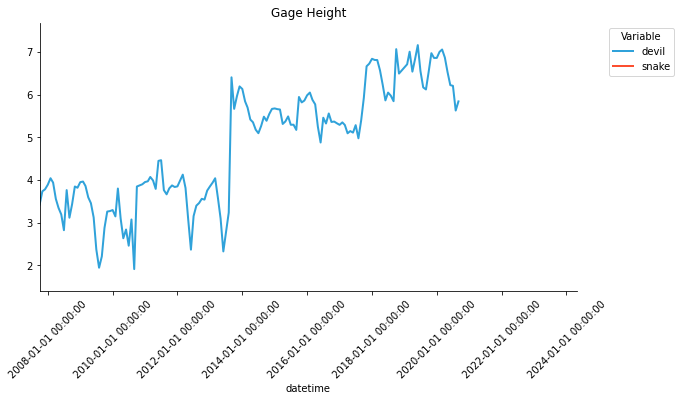

In [55]:
import hvplot.pandas
hvplot.extension('matplotlib')

(
    snake
    .with_columns(source=pl.lit('snake'))
    .select(common_cols)
    .vstack(
        dd2
        .with_columns(source=pl.lit('devil'))
        .select(common_cols)
    )
    .sort('datetime')
    .group_by_dynamic(
        index_column='datetime',
        every='1mo',
        group_by='source'
    )
    .agg(pl.col('gage_height').mean())
    .pivot(
        on='source',
        index='datetime',
        values='gage_height'
    )
    .filter(~pl.all_horizontal(pl.col('devil', 'snake').is_null()))
    .to_pandas()  # Convert to pandas DataFrame
    .hvplot(
        x='datetime',
        y=['devil', 'snake'],
        rot=45,
        title='Gage Height',
        width=800,
        height=400
    )
)




# 7.9 Window Functions in Polars
[back to Top](#Top)

* *Window functions* are a powerful tool for doing complex data manipulations.
* Think of a window function as a function that operates on a set of rows, where a window frame defines the set of rows.
* The result of a window function is a value for each row in the window frame.
* **GB: This is possibly how Polars offers functionality akin to row-wise operations without a Pandas-like index.**

---
        Period/Offset Description
        -----------------------------
        ns nanoseconds
        us microseconds
        ms milliseconds 
        s seconds
        m minutes
        h hours
        d days
        w weeks
        mo months
        q quarters
        y years
        i index count
        
* An example of a window function is the *rolling average* function, which calculates the average of a set of rows related to the current row.
* You can prefix the period with a number to specify the number of periods.
* For ex, 3d is 3 days, 2w is 2 weeks, 1y is 1 year.
* Use `index_count` to do a rolling operation on an index column.
* To do every 10 rows, use `10i` on a monotonic column.
* Here, find the mean cfs over the months, and add another column with the rolling average of the cfs over the last 3 months.

In [56]:
dd2['datetime']

datetime
"datetime[μs, America/Denver]"
2001-05-07 01:00:00 MDT
2001-05-07 01:15:00 MDT
2001-05-07 01:30:00 MDT
2001-05-07 01:45:00 MDT
2001-05-07 02:00:00 MDT
…
2020-09-28 08:30:00 MDT
2020-09-28 08:45:00 MDT
2020-09-28 09:00:00 MDT


In [57]:
(
    dd2
    .set_sorted('datetime')
    # group_by does not allow using 1mo, etc
    .group_by_dynamic(index_column='datetime', every='1mo')
    .agg(pl.col('cfs').mean())
    .with_columns(
        mean_cfs_3mo = pl.col('cfs')
                        .mean()
                        .rolling('datetime', period='3mo')
    )
)

datetime,cfs,mean_cfs_3mo
"datetime[μs, America/Denver]",f64,f64
2001-05-01 00:00:00 MDT,48.8702,48.8702
2001-06-01 00:00:00 MDT,22.946759,35.90848
2001-07-01 00:00:00 MDT,18.0125,29.943153
2001-08-01 00:00:00 MDT,248.004398,96.321219
2001-09-01 00:00:00 MDT,29.152574,98.389824
…,…,…
2020-05-01 00:00:00 MDT,22.670635,73.275465
2020-06-01 00:00:00 MDT,10.219805,33.748688
2020-07-01 00:00:00 MDT,25.042315,19.310918


* Visualize the results.

In [58]:
import hvplot
hvplot.extension('plotly')

(
    dd2
    .set_sorted('datetime')
    .group_by_dynamic( index_column='datetime', every='1mo')
    .agg(pl.col('cfs').mean())
    .with_columns(
        mean_cfs_3mo = pl.col('cfs')
                        .mean()
                        .rolling('datetime', period='3mo')
    )
    .hvplot(
        x='datetime',
        y=['cfs', 'mean_cfs_3mo']
    )
)

/Users/gpb/Desktop/python-3.11.5-pytorch/env/lib/python3.11/site-packages/panel/io/notebook.py:201: BokehUserWarning:

out of range integer may result in loss of precision

/Users/gpb/Desktop/python-3.11.5-pytorch/env/lib/python3.11/site-packages/panel/io/notebook.py:201: BokehUserWarning:

out of range integer may result in loss of precision



:NdOverlay   [Variable]
   :Curve   [datetime]   (value)

* There is a big outlier in 2006 or 2007.
* Clip the results to zoon in on the plot.

In [59]:
cfs_max = 1000

(
    dd2
    .set_sorted('datetime')
    .group_by_dynamic( index_column='datetime', every='1mo')
    .agg(pl.col('cfs').mean())
    .with_columns(
        pl.col('cfs').clip(upper_bound=cfs_max), # line 1
        mean_cfs_3mo = pl.col('cfs') # line 2
                        .mean()
                        .rolling('datetime', period='3mo')
                        .clip(upper_bound=cfs_max)
    )
    .hvplot(
        x='datetime',
        y=['cfs', 'mean_cfs_3mo']
    )
)

/Users/gpb/Desktop/python-3.11.5-pytorch/env/lib/python3.11/site-packages/panel/io/notebook.py:201: BokehUserWarning:

out of range integer may result in loss of precision

/Users/gpb/Desktop/python-3.11.5-pytorch/env/lib/python3.11/site-packages/panel/io/notebook.py:201: BokehUserWarning:

out of range integer may result in loss of precision



:NdOverlay   [Variable]
   :Curve   [datetime]   (value)

---
# 7.10 Interpolation
[back to Top](#Top)

* A common operation in time series data is dealing with missing values.
* Find the missing values for the *cfs* column.

In [60]:
(
    dd2
    .filter(
        pl.col('cfs').is_null()
    )
)

dataframe filtered


agency_cd,site_no,tz_cd,datetime,cfs,gage_height
str,i64,str,"datetime[μs, America/Denver]",f64,f64
"""USGS""",9333500,"""MST""",2007-12-15 00:00:00 MST,null,3.8
"""USGS""",9333500,"""MST""",2007-12-15 00:15:00 MST,null,3.78
"""USGS""",9333500,"""MST""",2007-12-15 00:30:00 MST,null,3.77
"""USGS""",9333500,"""MST""",2007-12-15 00:45:00 MST,null,3.76
"""USGS""",9333500,"""MST""",2007-12-15 01:00:00 MST,null,3.74
…,…,…,…,…,…
"""USGS""",9333500,"""MDT""",2020-09-12 00:15:00 MDT,null,5.47
"""USGS""",9333500,"""MDT""",2020-09-12 00:30:00 MDT,null,5.48
"""USGS""",9333500,"""MDT""",2020-09-12 00:45:00 MDT,null,5.48


* Zoom in an arbitrary time interval.
* Use `.is_between()` to filter the dataframe to only includes the date in a specific time period, such as Sept 2009.
* Because our *datetime* column has time zones, we need to ensure the `datetime` objects we create are also in the same time zone.
* This code will fail if the datetime objects are naive (no time zones)

In [61]:
dd2.select(pl.col('datetime'))

datetime
"datetime[μs, America/Denver]"
2001-05-07 01:00:00 MDT
2001-05-07 01:15:00 MDT
2001-05-07 01:30:00 MDT
2001-05-07 01:45:00 MDT
2001-05-07 02:00:00 MDT
…
2020-09-28 08:30:00 MDT
2020-09-28 08:45:00 MDT
2020-09-28 09:00:00 MDT


In [62]:
import datetime
import pytz

denver = pytz.timezone('America/Denver')
start_date = datetime.datetime(2007, 12, 14).replace(tzinfo=denver)
end_date = datetime.datetime(2007, 12, 19).replace(tzinfo=denver)

(
    dd2
    .filter(pl.col('datetime').is_between(start_date, end_date))
    .filter(pl.col('cfs').is_null())
)

dataframe filtered
dataframe filtered


agency_cd,site_no,tz_cd,datetime,cfs,gage_height
str,i64,str,"datetime[μs, America/Denver]",f64,f64
"""USGS""",9333500,"""MST""",2007-12-15 00:00:00 MST,null,3.8
"""USGS""",9333500,"""MST""",2007-12-15 00:15:00 MST,null,3.78
"""USGS""",9333500,"""MST""",2007-12-15 00:30:00 MST,null,3.77
"""USGS""",9333500,"""MST""",2007-12-15 00:45:00 MST,null,3.76
"""USGS""",9333500,"""MST""",2007-12-15 01:00:00 MST,null,3.74
…,…,…,…,…,…
"""USGS""",9333500,"""MST""",2007-12-17 22:45:00 MST,null,3.35
"""USGS""",9333500,"""MST""",2007-12-17 23:00:00 MST,null,3.34
"""USGS""",9333500,"""MST""",2007-12-17 23:15:00 MST,null,3.34


* Plot the above rows where the data is missing values.

In [63]:
(
    dd2
    .filter(pl.col('datetime').is_between(start_date, end_date))
    .hvplot(x='datetime', y=['cfs'])
)

dataframe filtered


/Users/gpb/Desktop/python-3.11.5-pytorch/env/lib/python3.11/site-packages/panel/io/notebook.py:201: BokehUserWarning:

out of range integer may result in loss of precision

/Users/gpb/Desktop/python-3.11.5-pytorch/env/lib/python3.11/site-packages/panel/io/notebook.py:201: BokehUserWarning:

out of range integer may result in loss of precision



:Curve   [datetime]   (cfs)

---
* The following show ways of filling in missing values.
* For easier visualization, shift each line by an offset amount.

In [64]:
(
    dd2
        .filter(pl.col('datetime').is_between(start_date, end_date))
        .select(pl.col('cfs')).mean()
    )

dataframe filtered


cfs
f64
78.724352


In [65]:
offset = 5

(
    dd2
    .filter(pl.col('datetime').is_between(start_date, end_date))
    .with_columns(
         # x-axis
        'datetime',
        # y-axis
        'cfs',
        fill0=pl.col('cfs').fill_null(0).add(offset),
        fill_mean=pl.col('cfs').fill_null(strategy='mean').add(offset),
        interpolate=pl.col('cfs').interpolate().add(offset*2),
        forward=pl.col('cfs').fill_null(strategy='forward').add(offset*3),
        backward=pl.col('cfs').fill_null(strategy='backward').add(offset*4)
    )
    .hvplot(
        x='datetime',
        y=['cfs', 'fill0', 'interpolate', 'forward', 'backward', 'fill_mean']
        #y=['cfs']
    )
)

dataframe filtered


/Users/gpb/Desktop/python-3.11.5-pytorch/env/lib/python3.11/site-packages/panel/io/notebook.py:201: BokehUserWarning:

out of range integer may result in loss of precision

/Users/gpb/Desktop/python-3.11.5-pytorch/env/lib/python3.11/site-packages/panel/io/notebook.py:201: BokehUserWarning:

out of range integer may result in loss of precision



:NdOverlay   [Variable]
   :Curve   [datetime]   (value)



# 7.11 Upsampling and Downsampling
[back to Top](#Top)

* Sometimes you need to change the frequency of the data.
* *Upsampling* is when you increase the frequency of samples to a finer granularity.
* *Downsampling* is when you decreate the frequency of samples to a coarser granularity.
* Both methods are useful for merging data from different sources with different frequencies.

In this example:

* The river data is at a 15-minute frequency.
* Upsample to 5 minutes.
* Use `.upsample()` to upsample the data.
* Use `interpolate()` to interpolate the missing values.

---
* `polars.DataFrame.interpolate`
* https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.interpolate.html#polars.DataFrame.interpolate
* Interpolate intermediate values of dataframe. The interpolation method is linear.

In [66]:
(
    dd
    .set_sorted('datetime')
    .upsample('datetime', every='5m')
    .interpolate()
)

datetime,agency_cd,site_no,tz_cd,cfs,gage_height
datetime[μs],str,f64,str,f64,f64
2001-05-07 01:00:00,"""USGS""",9.3335e6,"""MDT""",71.0,null
2001-05-07 01:05:00,null,9.3335e6,null,71.0,null
2001-05-07 01:10:00,null,9.3335e6,null,71.0,null
2001-05-07 01:15:00,"""USGS""",9.3335e6,"""MDT""",71.0,null
2001-05-07 01:20:00,null,9.3335e6,null,71.0,null
…,…,…,…,…,…
2020-09-28 09:10:00,null,9.3335e6,null,9.2,6.15
2020-09-28 09:15:00,"""USGS""",9.3335e6,"""MDT""",9.2,6.15
2020-09-28 09:20:00,null,9.3335e6,null,9.2,6.15


## 7.11.1 groupby details

* If we try to use a groupby with finer granularity than the data, we will just get the original data back.
* For ex, if we try to group by every 5 minutes, we will just get back the original data back with a 15-minute frequency.

In [67]:
(
    dd
    
    # Think of .set_sorted().group_by_dynamic() as a pair, 
    # .group_by_dynamic basically does not work without it.
    .set_sorted('datetime') 
    .group_by_dynamic(index_column='datetime', every='5m')
    
    .agg(pl.col('cfs').mean())
)

datetime,cfs
datetime[μs],f64
2001-05-07 01:00:00,71.0
2001-05-07 01:15:00,71.0
2001-05-07 01:30:00,71.0
2001-05-07 01:45:00,70.0
2001-05-07 02:00:00,70.0
…,…
2020-09-28 08:30:00,9.53
2020-09-28 08:45:00,9.2
2020-09-28 09:00:00,9.2


---
* Downsample to 30 minutes.
* This is just doing a dynamic group by with a 30 minute interval.

## 7.11.2 `.group_by_dynamic` methods

These are the methods and attributes available on `.group_by_dynamic()`

    'agg',
    'apply',
    'check_sorted',
    'closed',
    'df',
    'every',
    'group_by',
    'include_boundaries',
    'label',
    'map_groups',
    'offset',
    'period',
    'start_by',
    'time_column',
    'truncate'

In [68]:
(
    dd
    .set_sorted('datetime')
    .group_by_dynamic(index_column='datetime', every='30m')
    .agg(pl.col('cfs').mean())
)

datetime,cfs
datetime[μs],f64
2001-05-07 01:00:00,71.0
2001-05-07 01:30:00,70.5
2001-05-07 02:00:00,69.5
2001-05-07 02:30:00,70.0
2001-05-07 03:00:00,70.0
…,…
2020-09-28 07:30:00,9.365
2020-09-28 08:00:00,9.365
2020-09-28 08:30:00,9.365


---
# 7.12 Joining Time Series Data
[back to Top](#Top)


* Load some meteorological data from Hanksville, Utah.
* Data from https://raw.githubusercontent.com/mattharrison/datasets/master/data/hanksville.csv
* Combine both datasets to have flow data, temperature and precipitation information in the same dataset.
* Some of the main columns are:

        • DATE - Date
        • PRCP - Precipitation in inches
        • TMIN - Minimum temperature (F) for day
        • TMAX - Maximum temperature (F) for day
        • TOBS - Observed temperature (F) when measurement made

In [69]:
url_hanksville = 'https://raw.githubusercontent.com/mattharrison/datasets/master/data/hanksville.csv'
url_file_hanksville = './data/data_river_hanksville.csv'

!wget -P ./data -O $url_file_hanksville -nc $url_hanksville

--2024-10-25 11:16:02--  https://raw.githubusercontent.com/mattharrison/datasets/master/data/hanksville.csv
raw.githubusercontent.com (raw.githubusercontent.com) をDNSに問いあわせています... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 830595 (811K) [text/plain]
`./data/data_river_hanksville.csv' に保存中

data_river_hanksvil 100%[===================>] 811.13K  --.-KB/s 時間 0.1s       

2024-10-25 11:16:02 (6.20 MB/s) - `./data/data_river_hanksville.csv' へ保存完了 [830595/830595]



In [70]:
# check columns
raw_temp = pl.read_csv(url_file_hanksville)

raw_temp.describe()

avg line length: 122.4082
std. dev. line length: 2.4869459
initial row estimate: 6785
no. of chunks: 4 processed by: 4 threads.


statistic,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,MDPR,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT05,WT06,WT11
str,str,str,f64,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str
"""count""","""6848""","""6848""",6848.0,6848.0,6848.0,"""6848""","""2""","""2""",6638.0,6166.0,6086.0,6835.0,6824.0,6766.0,"""86""","""288""","""9""","""33""","""3""","""60"""
"""null_count""","""0""","""0""",0.0,0.0,0.0,"""0""","""6846""","""6846""",210.0,682.0,762.0,13.0,24.0,82.0,"""6762""","""6560""","""6839""","""6815""","""6845""","""6788"""
"""mean""",null,null,38.37497,-110.71906,1304.5,null,null,null,0.017046,0.021132,0.042721,72.762985,38.670868,56.831954,null,null,null,null,null,null
"""std""",null,null,7.1059e-15,1.4212e-14,0.0,null,null,null,0.08419,0.229205,0.325547,21.307001,18.072106,21.886646,null,null,null,null,null,null
"""min""","""USW00023170""","""HANKSVILLE, UT US""",38.37497,-110.71906,1304.5,"""2000-01-01""",""" 2""","""0.02""",0.0,0.0,0.0,18.0,-12.0,-3.0,""" 1""",""" 1""",""" 1""",""" 1""",""" 1""",""" 1"""
"""25%""",null,null,38.37497,-110.71906,1304.5,null,null,null,0.0,0.0,0.0,55.0,24.0,39.0,null,null,null,null,null,null
"""50%""",null,null,38.37497,-110.71906,1304.5,null,null,null,0.0,0.0,0.0,73.0,39.0,57.0,null,null,null,null,null,null
"""75%""",null,null,38.37497,-110.71906,1304.5,null,null,null,0.0,0.0,0.0,92.0,54.0,75.0,null,null,null,null,null,null
"""max""","""USW00023170""","""HANKSVILLE, UT US""",38.37497,-110.71906,1304.5,"""2020-09-24""",""" 2""","""0.03""",3.07,5.0,5.0,114.0,83.0,106.0,""" 1""",""" 1""",""" 1""",""" 1""",""" 1""",""" 1"""


In [71]:
def tweak_temp(df_):
    return (
        df_
        .select(
            pl.col('DATE')
                .str.to_datetime()
                .dt.replace_time_zone('America/Denver'),
            'PRCP',
            'TMIN',
            'TMAX',
            'TOBS'
        )
    )

tweak_temp(raw_temp)

DATE,PRCP,TMIN,TMAX,TOBS
"datetime[μs, America/Denver]",f64,i64,i64,i64
2000-01-01 00:00:00 MST,0.02,21,43,28
2000-01-02 00:00:00 MST,0.03,24,39,24
2000-01-03 00:00:00 MST,0.0,7,39,18
2000-01-04 00:00:00 MST,0.0,5,39,25
2000-01-05 00:00:00 MST,0.0,10,44,22
…,…,…,…,…
2020-09-20 00:00:00 MDT,0.0,46,92,83
2020-09-21 00:00:00 MDT,0.0,47,92,84
2020-09-22 00:00:00 MDT,0.0,54,84,77


---
* This data looks to be sorted on a daily basis.
* If we join the flow data with the temperature data, we downsample the flow data to the daily level.
* Then, we can join the data based on the dates.

In [72]:
# Downsample dd2 to daily level
dd_daily = (
    dd2
    .set_sorted('datetime')
    .group_by_dynamic(
        index_column='datetime',
        every='1d',
    )
    .agg(pl.col('gage_height', 'cfs').mean())
)
dd_daily

datetime,gage_height,cfs
"datetime[μs, America/Denver]",f64,f64
2001-05-07 00:00:00 MDT,null,71.076087
2001-05-08 00:00:00 MDT,null,69.208333
2001-05-09 00:00:00 MDT,null,61.197917
2001-05-10 00:00:00 MDT,null,55.041667
2001-05-11 00:00:00 MDT,null,54.78125
…,…,…
2020-09-24 00:00:00 MDT,6.156042,9.410208
2020-09-25 00:00:00 MDT,6.175208,10.041042
2020-09-26 00:00:00 MDT,6.204896,11.062292


* If you are joining date columns, both date columns need the same time zone for Polars to join them.

---
Continuing:

* Combine the two dataframes to have daily flow and temperature in a single dataframe.
* Use `.join()` to join them.

In [73]:
both=(
    tweak_temp(raw_temp)
    .join(
        dd_daily,
        left_on='DATE',
        right_on='datetime',
        # validat='1:1': Checks if the join keys are unique in both 
        # the left and right DataFrames, ensuring a one-to-one join.
        validate='1:1'
    )
)
both

join parallel: true
INNER join triggered a rechunk of the right DataFrame: 3 columns are affected
INNER join dataframes finished


DATE,PRCP,TMIN,TMAX,TOBS,gage_height,cfs
"datetime[μs, America/Denver]",f64,i64,i64,i64,f64,f64
2001-05-07 00:00:00 MDT,0.0,41,82,55,null,71.076087
2001-05-08 00:00:00 MDT,0.0,43,85,58,null,69.208333
2001-05-09 00:00:00 MDT,0.0,36,92,64,null,61.197917
2001-05-10 00:00:00 MDT,0.0,50,92,67,null,55.041667
2001-05-11 00:00:00 MDT,0.0,46,87,60,null,54.78125
…,…,…,…,…,…,…
2020-09-20 00:00:00 MDT,0.0,46,92,83,6.060938,6.603542
2020-09-21 00:00:00 MDT,0.0,47,92,84,6.065104,6.714479
2020-09-22 00:00:00 MDT,0.0,54,84,77,6.085521,7.277812


---
# 7.13 Visualizing the Merged Data
[back to Top](#Top)

* Plot the temperature and cfs of the river data.
* Make a line plot of all of the past years level, in light-color
* Plot the median and most recent year in bold-color

Directions:

* Join the data and sort the results.
* Make three dataframes.
* One is a pivot of the weekly rolling median values for daily temperature for each year.
* Another dataframe is for the last year.
* The last dataframe is for median values.
* Use Bokeh as the backend for the plots.

In [74]:
import holoviews as hv

#hvplot.extension('bokeh')
hvplot.extension('matplotlib')

year_agg=(
    both
    .with_columns(
        day_of_year=pl.col('DATE').dt.strftime('%j').cast(pl.Int16),
        year=pl.col('DATE').dt.year()
    )
    .pivot(
        index='day_of_year',
        on='year',
        values='TOBS'
    )
    .sort(by='day_of_year')
)
year_agg.head(2)

day_of_year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2014,2015,2016,2017,2018,2019,2020
i16,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1,null,28,20,null,null,null,null,10,21,21,4,20,null,23,26,null,40,22,20
2,null,30,20,null,null,null,null,12,27,18,12,20,null,11,30,44,38,20,22


:NdOverlay   [Variable]
   :Curve   [day_of_year]   (value)
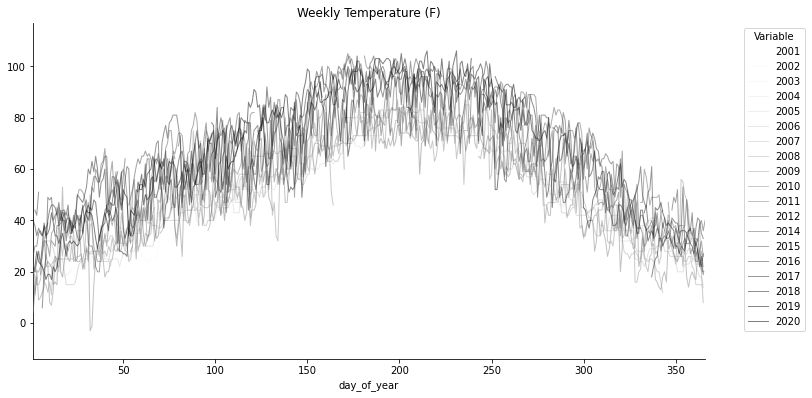

In [75]:
p1 = (
    year_agg
    .with_columns(
        pl.col([
        '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', 
        #'2010', '2011', '2012', '2014', '2015', '2016', '2017', '2018', '2019',
        ])
    .rolling_median(7)
    )
    .hvplot(
        x='day_of_year',
        alpha=0.5,
        #line_width=1,
        linewidth=1,
        color=hv.Palette('Greys'),
        title='Weekly Temperature (F)',
        width=1_000,
        height=500
    )
)

p1

:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [day_of_year]   (value)
   .Curve.A_2009 :Curve   [day_of_year]   (2009)
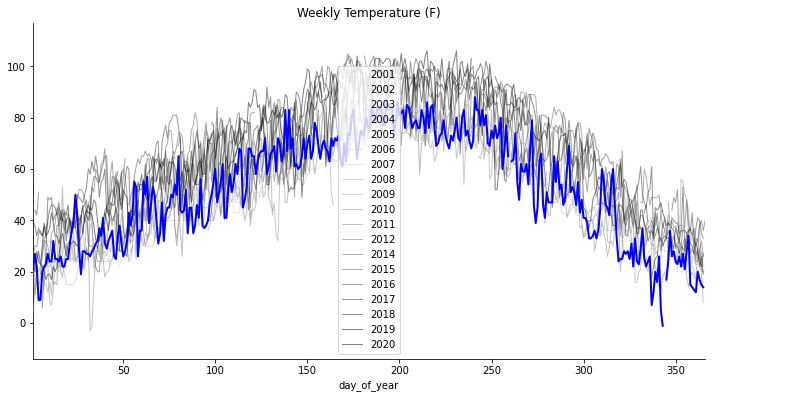

In [76]:
# Make the last year thicker and blue
p2 = p1 * (year_agg
    .select(pl.col('day_of_year', '2009'))
    .hvplot(x='day_of_year', y='2009', color='blue', 
          #line_width=2,
          linewidth=2,
          label='2009')
)

p2

:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [day_of_year]   (value)
   .Curve.A_2009 :Curve   [day_of_year]   (2009)
   .Curve.Median :Curve   [day_of_year]   (Median)
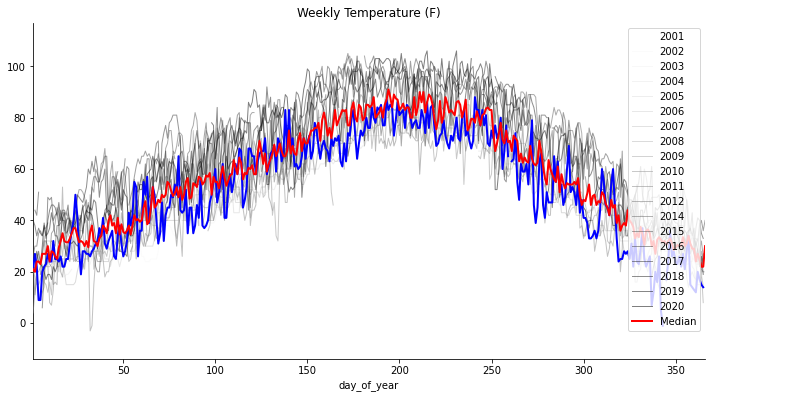

In [77]:
# add median in red
p3 =  p2 * (both
    .with_columns(
        day_of_year=pl.col('DATE').dt.strftime('%j').cast(pl.Int16), 
        median=pl.lit('Median')
    )
    .pivot(
        index='day_of_year', 
        on='median', 
        values='TOBS', 
        aggregate_function='median'
    )
    .sort('day_of_year')
    .hvplot(x='day_of_year', y='Median', c='r', label='Median')
) 

p3

* Refactor this into a function.

In [78]:
def plot_year_last_year_median(
    df,
    col,
    upper_limit=None,
    lower_limit=None,
    width=1_000,
    height=500
):
    if upper_limit is None:
        upper_limit = df[col].max()

    year_agg = (
        df
        .with_columns(
            day_of_year=pl.col('DATE').dt.strftime('%j').cast(pl.Int16),
            year=pl.col('DATE').dt.year()
        )
        .pivot(
            index='day_of_year', 
            on='year', 
            values=col
        )
        .sort('day_of_year')
    )

    # previous years in grey thin lines
    p1 = (
        year_agg
        .with_columns(pl.col(
            [
                '2001', '2002', '2003', '2004', '2005', 
                '2006', '2007', '2008', '2009'
            ]
        ).rolling_median(7).clip(upper_bound=upper_limit))
        .hvplot(
            x='day_of_year',
            alpha=1,
            color=hv.Palette('Greys'),
            #line_width=.5,
            linewidth=.5,
            width=width,
            height=height
        )
    )


    # Make the 2009 thicker and blue
    p2 = p1*(year_agg
        .select(
            'day_of_year', 
            pl.col('2009').rolling_median(7).clip(upper_bound=upper_limit))
            .hvplot(
                x='day_of_year', 
                y='2009', 
                color='blue', 
                label='2009',
                #line_width=2,
                linewidth=2,
                title=f'Weekly {col}', 

            )
        )

    # add median in red
    p3 = p2 * (
        df
        .with_columns(
            day_of_year=pl.col('DATE').dt.strftime('%j').cast(pl.Int16),
            median=pl.lit('Median'))
        .pivot(
            index='day_of_year',
            on='median',
            values=col,
            aggregate_function='median'
        )
        .sort('day_of_year')
        .with_columns(
            pl.col('Median').rolling_mean(7).clip(upper_bound=upper_limit)
        )      
        .hvplot(
            x='day_of_year', 
            y='Median', 
            color='red', 
            label='Median',
            linewidth=2,
        )
    )
    return p3

:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [day_of_year]   (value)
   .Curve.A_2009 :Curve   [day_of_year]   (2009)
   .Curve.Median :Curve   [day_of_year]   (Median)
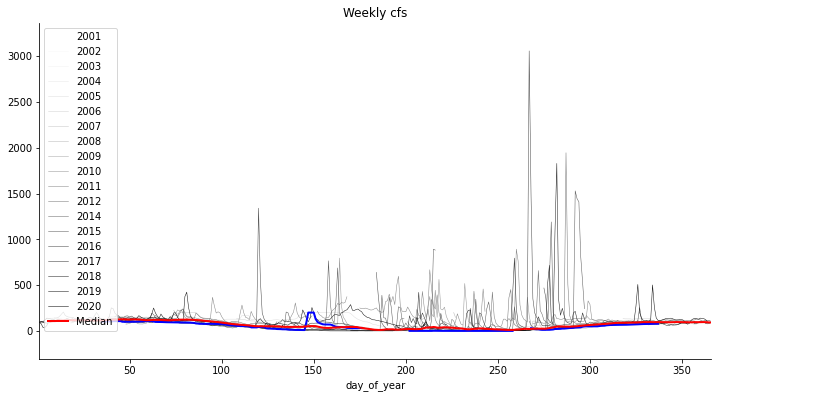

In [79]:
plot_year_last_year_median(
    both,
    'cfs',
    upper_limit=200
)

---
# 7.14 Chapter Methods and Functions
[back to Top](#Top)

TO-DO